# Ising Model

In physics, an MCMC simulation can be used, for example, to understand how quan‐
tum transitions in individual molecules can affect aggregate ensemble measurements
of that system over time. In this case, we need to apply a few specific rules:

1. In a Markov process, the probability of a transition to a state in the future
depends only on the present state (not on past information).
2. We will impose a physics-specific condition of requiring a Boltzmann distribu‐
-b E -E
tion for energy; that is, $T_{ij} / T_{ji} = e^{( E_j - E_i )}$ . For most of us, this is just an imple‐
mentation detail and not something nonphysicists need to worry about.

We implement an MCMC simulation as follows:

1. Select the starting state of each individual lattice site randomly.
2. For each individual time step, choose an individual lattice site and flip its
    direction.
3. Calculate the change in energy that would result from this flip given the physical
    laws you are working with. In this case this means:
    - If the change in energy is negative, you are transitioning to a lower energy
        state, which will always be favored, so you keep the switch and move on to the
        next time step.
    - If the change in energy is not negative, you accept it with the acceptance prob‐
         ability of e (-energy change) . This is consistent with rule 2.

Continue steps 2 and 3 indefinitely until convergence to determine the most likely
state for whatever aggregate measurement you are making.

Let’s take a look at the specific details of the Ising model. Imagine we have a two-
dimensional material composed of a grid of objects, each one having what boils down
to a mini-magnet that can point up or down. We put those mini-magnets randomly
in an up or down spin at time zero, and we then record the system as it evolves from
a random state to an ordered state at low temperature.

In [4]:
import numpy as np

In [5]:
# config
N = 5 # width of lattice
M = 5 # height of lattice

# temperature settings
temperature = 0.5
BETA = 1/temperature

In [6]:
def init_random_state(N, M):
    block = np.random.choice([-1, 1], size = (N, M))
    return block

We also calculate the energy for a given center state alignment relative to its
neighbors:

In [7]:
def cost_for_center_state(state, i, j, n, m):
    centerS = state[i, j]
    neighbors = [
        ((i + 1) % n, j), ((i - 1) % n, j),
        (i, (j + 1) % m), (i, (j - 1) % m)
    ]
    interactionE = [state[x, y] * centerS for (x, y) in neighbors]
    return np.sum(interactionE)

And we want to determine the magnetization of the entire block for a given state:

In [8]:
def magnetization_for_state(state):
    return np.sum(state)

Here’s where we introduce the MCMC steps discussed earlier:

In [10]:
def mcmc_adjust(state):
    n = state.shape[0]
    m = state.shape[1]
    x, y = np.random.randint(0, n), np.random.randint(0, m)
    centerS = state[x, y]
    cost = cost_for_center_state(state, x, y, n, m)
    if cost < 0:
        centerS *= -1
    elif np.random.random() < np.exp(-cost * BETA):
        centerS *= -1
    state[x, y] = centerS
    return state

Now to actually run a simulation, we need some recordkeeping as well as repeated
calls to the MCMC adjustment:

In [15]:
def run_state(state, n_steps, snapsteps = None):
    if snapsteps is None:
        snapsteps = np.linspace(0, n_steps, num = round(n_steps / (M * N * 100)),
                                dtype = np.int32)
    saved_states = []
    sp = 0
    magnet_hist = []
    for i in range(n_steps):
        state = mcmc_adjust(state)
        magnet_hist.append(magnetization_for_state(state))
        if sp < len(snapsteps) and i == snapsteps[sp]:
            saved_states.append(np.copy(state))
            sp += 1
    return state, saved_states, magnet_hist

In [16]:
# run simulation
init_state = init_random_state(N, M)
print(init_state)
final_state = run_state(np.copy(init_state), 1000)

[[-1  1  1 -1 -1]
 [-1 -1 -1 -1  1]
 [-1 -1  1  1  1]
 [ 1  1  1 -1 -1]
 [-1 -1 -1 -1 -1]]


In [17]:
print(final_state)

(array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]]), [], [-7, -7, -7, -9, -11, -11, -13, -13, -15, -13, -15, -15, -15, -15, -15, -15, -15, -15, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -17, -19, -19, -19, -19, -19, -19, -19, -19, -19, -19, -21, -21, -21, -21, -21, -21, -21, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -

We do this with magnetization over time for many independent runs of the previous
simulation

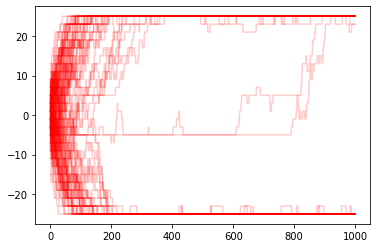

In [19]:
results = []
for i in range(100):
    init_state = init_random_state(N, M)
    final_state, states, magnet_hist = run_state(init_state, 1000)
    results.append(magnet_hist)

# we plot each curve with some transparency so we can
# see curves that overlap
import matplotlib.pyplot as plt
for mh in results:
    plt.plot(mh, 'r', alpha = 0.2)

The magnetization curves are just one example of how we could picture the system
evolving over time. We might also consider recording 2D time series, as the snapshot
of the overall state at each point in time. Or there might be other interesting aggre‐
gate variables to measure at each step, such as a measure of layout entropy or a meas‐
ure of total energy. Quantities such as magnetization or entropy are related
quantities, as they are a function of the geometric layout of the state at each lattice
site, but each quantity is a slightly different measure.